In [14]:
import xarray as xr
import pandas as pd
import numpy as np
from scipy import interpolate
import glob
import os
import gsw

def loop_on_file(path):
    
    #init output
    new_depth=np.arange(5,705,5)
    #init new dataset
    new_ds=xr.Dataset({'temp':(['N_PROF','DEPTH'],np.empty([0,len(new_depth)])*np.nan),
                   'latitude':(['N_PROF'],np.empty(0)),
                   'longitude':(['N_PROF'],np.empty(0)),
                   'juld':(['N_PROF'],np.empty(0)),
                   'platform_number':(['N_PROF'],np.empty(0)),
                   'wmo_inst_type':(['N_PROF'],np.empty(0)),
                   },
                   coords={'DEPTH':new_depth})   
    #go   
    DAT=xr.open_dataset(path,decode_times=False)
        
    #CHECK FOR PRES,DEPH,TEMP,PSAL
    varlist=DAT.keys()
    #KEEP WHAT WE NEED
    plus=['PLATFORM_NUMBER','CYCLE_NUMBER','WMO_INST_TYPE','JULD','JULD_QC','LATITUDE','LONGITUDE',
          'POSITION_QC','REFERENCE_DATE_TIME']
    if ('TEMP' in varlist):
        plus=np.append(plus,['TEMP','TEMP_QC','TEMP_ADJUSTED'])
    if ('PRES' in varlist):
        plus=np.append(plus,['PRES','PRES_QC','PRES_ADJUSTED'])    
    if ('DEPH' in varlist):
        plus=np.append(plus,['DEPH','DEPH_QC','DEPH_ADJUSTED'])    
    DAT=DAT[plus]
    #AREA
    #DAT=DAT.where((DAT.LATITUDE>=28)&(DAT.LATITUDE<=45)&(DAT.LONGITUDE>=-79)&(DAT.LONGITUDE<=-35),drop=True)
    DAT=DAT.where((DAT.LATITUDE>=22)&(DAT.LATITUDE<=45)&(DAT.LONGITUDE>=123)&(DAT.LONGITUDE<=170),drop=True)
    
    if(len(DAT.N_PROF.values)>0):    
        #GET VARLIST
        varlist=DAT.keys()
        #REDUCE TO QC=1
        mask1 = (np.abs(DAT['TEMP']) != np.nan) & (DAT['TEMP_QC'] == '1')
        mask2 = (DAT['JULD_QC'] == '1') & (DAT['POSITION_QC'] == '1')
        if ('DEPH' in varlist)&('PRES' in varlist):
            mask3=((np.abs(DAT['DEPH'])!=np.nan)|(np.abs(DAT['PRES'])!=np.nan))&((DAT['DEPH_QC']=='1')|(DAT['PRES_QC']=='1'))
        elif ('DEPH' in varlist):
            mask3=(np.abs(DAT['DEPH']) != np.nan) & (DAT['DEPH_QC'] == '1')
        elif ('PRES' in varlist):   
            mask3=(np.abs(DAT['PRES']) != np.nan) & (DAT['PRES_QC'] == '1')

        DAT = DAT.where(mask1 & mask2 & mask3, drop=True)

        if(len(DAT.N_PROF.values)>0):    
            #AT LEAST 10 POINTS ON PROFILE WITH MIN DEPTH =< 10m & MAX DEPHT >= 700m
            if ('DEPH' in varlist)&('PRES' in varlist):
                H = DAT['DEPH'].where(DAT['TEMP'].notnull()).max(dim='N_LEVELS')
                G = DAT['DEPH'].where(DAT['TEMP'].notnull()).min(dim='N_LEVELS')
                Hb = DAT['PRES'].where(DAT['TEMP'].notnull()).max(dim='N_LEVELS')
                Gb = DAT['PRES'].where(DAT['TEMP'].notnull()).min(dim='N_LEVELS')
                DAT = DAT.where(((H>=700)|(Hb>=710))&((G<=10)|(Gb<=10)),drop=True)    
            elif ('DEPH' in varlist):
                H = DAT['DEPH'].where(DAT['TEMP'].notnull()).max(dim='N_LEVELS')
                G = DAT['DEPH'].where(DAT['TEMP'].notnull()).min(dim='N_LEVELS')
                DAT = DAT.where((H>=700)&(G<=10),drop=True)    
            elif ('PRES' in varlist):   
                H = DAT['PRES'].where(DAT['TEMP'].notnull()).max(dim='N_LEVELS')
                G = DAT['PRES'].where(DAT['TEMP'].notnull()).min(dim='N_LEVELS')
                DAT = DAT.where((H>=710)&(G<=10),drop=True)

            M = DAT['TEMP'].notnull().sum('N_LEVELS')
            DAT = DAT.where((M>=10),drop=True) 

            #REDUCE DIMENSIONS
            DAT['A']=DAT['REFERENCE_DATE_TIME'].min(dim='N_LEVELS')
            DAT['C']=DAT['PLATFORM_NUMBER'].min(dim='N_LEVELS')
            DAT['D']=DAT['WMO_INST_TYPE'].min(dim='N_LEVELS')
            DAT['E']=DAT['CYCLE_NUMBER'].min(dim='N_LEVELS')
            DAT['F']=DAT['JULD'].min(dim='N_LEVELS')
            DAT['Fb']=DAT['JULD_QC'].min(dim='N_LEVELS')
            DAT['G']=DAT['LATITUDE'].min(dim='N_LEVELS')
            DAT['H']=DAT['LONGITUDE'].min(dim='N_LEVELS')
            DAT['I']=DAT['POSITION_QC'].min(dim='N_LEVELS')
            DAT=DAT.drop(['REFERENCE_DATE_TIME','PLATFORM_NUMBER','WMO_INST_TYPE','CYCLE_NUMBER',
                         'JULD','JULD_QC','LATITUDE','LONGITUDE','POSITION_QC'])
            DAT=DAT.rename({'A':'REFERENCE_DATE_TIME','C':'PLATFORM_NUMBER',
                            'D':'WMO_INST_TYPE','E':'DC_REFERENCE','F':'JULD','Fb':'JULD_QC','G':'LATITUDE',
                            'H':'LONGITUDE','I':'POSITION_QC'})
        
            if(len(DAT.N_PROF.values)>0):
                #KEEP ADJUSTED IF BETTER AND CALCULATE DEPTH WHEN PRES PROVIDED
                #CREATE DEPTH ARRAY
                DAT=DAT.assign(DEPTH = np.nan*DAT.TEMP)

                for i in DAT.N_PROF.values:
                    if (DAT.TEMP_ADJUSTED[i,:].notnull().sum('N_LEVELS')>=DAT.TEMP[i,:].notnull().sum('N_LEVELS')):
                        DAT.TEMP[i,:]=DAT.TEMP_ADJUSTED[i,:].values

                    if ('DEPH' in varlist)&('PRES' in varlist):
                        #ADJUSTED
                        if (DAT.DEPH_ADJUSTED[i,:].notnull().sum('N_LEVELS')>=DAT.DEPH[i,:].notnull().sum('N_LEVELS')):
                            DAT.DEPH[i,:]=DAT.DEPH_ADJUSTED[i,:].values
                        if (DAT.PRES_ADJUSTED[i,:].notnull().sum('N_LEVELS')>=DAT.PRES[i,:].notnull().sum('N_LEVELS')):
                            DAT.PRES[i,:]=DAT.PRES_ADJUSTED[i,:].values   
                        #CALCULATE DEPTH    
                        if (DAT.DEPH[i,:].notnull().sum('N_LEVELS')<DAT.PRES[i,:].notnull().sum('N_LEVELS')):
                            DAT.DEPTH[i,:]=gsw.z_from_p(DAT.PRES[0,:].values,DAT.LATITUDE[0])*-1    
                        else:
                            DAT.DEPTH[i,:]=DAT.DEPH[i,:]

                    elif ('DEPH' in varlist):
                        #ADJUSTED
                        if (DAT.DEPH_ADJUSTED[i,:].notnull().sum('N_LEVELS')>=DAT.DEPH[i,:].notnull().sum('N_LEVELS')):
                            DAT.DEPH[i,:]=DAT.DEPH_ADJUSTED[i,:].values
                        DAT.DEPTH[i,:]=DAT.DEPH[i,:]    
                    elif ('PRES' in varlist):   
                        #ADJUSTED
                        if (DAT.PRES_ADJUSTED[i,:].notnull().sum('N_LEVELS')>=DAT.PRES[i,:].notnull().sum('N_LEVELS')):
                            DAT.PRES[i,:]=DAT.PRES_ADJUSTED[i,:].values
                        #CALCULATE DEPTH                
                        DAT.DEPTH[i,:]=gsw.z_from_p(DAT.PRES[i,:].values,DAT.LATITUDE[i])*-1

                if ('PRES' in varlist):   
                    DAT=DAT.drop(['PRES','PRES_ADJUSTED','PRES_QC'])    
                if ('DEPH' in varlist):   
                    DAT=DAT.drop(['DEPH','DEPH_ADJUSTED','DEPH_QC'])    
                DAT=DAT.drop(['TEMP_ADJUSTED','TEMP_QC','JULD_QC','POSITION_QC'])    

                if(len(DAT.N_PROF.values)>0):    
                    #INTERPOLATION OF GOOD PROFILES
                    new_depth=np.arange(5,705,5)
                    #init new dataset
                    new_ds=xr.Dataset({'temp':(['N_PROF','DEPTH'],np.empty([len(DAT.N_PROF.values),len(new_depth)])*np.nan),
                                       'latitude':(['N_PROF'],DAT.LATITUDE.values),
                                       'longitude':(['N_PROF'],DAT.LONGITUDE.values),
                                       'juld':(['N_PROF'],DAT.JULD.values),
                                       'platform_number':(['N_PROF'],DAT.PLATFORM_NUMBER.values),
                                       'wmo_inst_type':(['N_PROF'],DAT.WMO_INST_TYPE.values),
                                      },
                                      coords={'DEPTH':new_depth})   
                    new_ds.attrs=DAT.attrs
                    new_ds.temp.attrs=DAT.TEMP.attrs
                    new_ds.latitude.attrs=DAT.LATITUDE.attrs
                    new_ds.longitude.attrs=DAT.LONGITUDE.attrs
                    new_ds.juld.attrs=DAT.JULD.attrs
                    new_ds.platform_number.attrs=DAT.PLATFORM_NUMBER.attrs
                    new_ds.wmo_inst_type.attrs=DAT.WMO_INST_TYPE.attrs                    

                    for i in DAT.N_PROF.values :
                        ccc=np.argwhere(~np.isnan(DAT.TEMP[i,:].values))                        
                        fnv=DAT.TEMP[i,ccc[0]].values
                        f=interpolate.interp1d(np.append(0,DAT.DEPTH[i,:].values),np.append(fnv,DAT.TEMP[i,:].values),
                                              kind='linear',bounds_error='False')
                        new_ds.temp[i,:]=f(new_depth)

    #OUT
    return new_ds

In [15]:
listyear=np.array(np.arange(1950,2018),dtype='S4')
for yeart in listyear:
    print yeart
    ROOT='/home/datawork-coriolis-cora-s/CORA_dataset/'
    path=glob.glob(os.path.join(ROOT+yeart+'/*_PR_*.nc'))
    path.sort()
    dsf=loop_on_file(path[0])
    for i in np.arange(1,len(path)):
        #LOGPLOT EVERY 20 FILES
        if(np.mod(i,30)==0):
            print path[i],' ...',i,'/',len(path)
        dsf=xr.concat([dsf,loop_on_file(path[i])],'N_PROF')
    dsf.to_netcdf('/export/home1/DATA/PIRATE/CORA/Kuroshio/PROFILES/'+'CORA_SDL_Kuroshio_TEMP_'+yeart+'.nc')    

1950
/home/datawork-coriolis-cora-s/CORA_dataset/1950/CO_DMQCGL01_19500116_PR_OC.nc  ... 30 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1950/CO_DMQCGL01_19500131_PR_OC.nc  ... 60 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1950/CO_DMQCGL01_19500215_PR_OC.nc  ... 90 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1950/CO_DMQCGL01_19500302_PR_OC.nc  ... 120 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1950/CO_DMQCGL01_19500317_PR_OC.nc  ... 150 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1950/CO_DMQCGL01_19500401_PR_OC.nc  ... 180 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1950/CO_DMQCGL01_19500416_PR_OC.nc  ... 210 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1950/CO_DMQCGL01_19500501_PR_OC.nc  ... 240 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1950/CO_DMQCGL01_19500516_PR_OC.nc  ... 270 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1950/CO_DMQCGL01_19500531_PR_OC.nc  ... 300 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1950/CO_DMQCGL

/home/datawork-coriolis-cora-s/CORA_dataset/1953/CO_DMQCGL01_19530913_PR_OC.nc  ... 510 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1953/CO_DMQCGL01_19530928_PR_OC.nc  ... 540 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1953/CO_DMQCGL01_19531013_PR_OC.nc  ... 570 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1953/CO_DMQCGL01_19531028_PR_OC.nc  ... 600 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1953/CO_DMQCGL01_19531112_PR_OC.nc  ... 630 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1953/CO_DMQCGL01_19531127_PR_OC.nc  ... 660 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1953/CO_DMQCGL01_19531212_PR_OC.nc  ... 690 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1953/CO_DMQCGL01_19531227_PR_OC.nc  ... 720 / 730
1954
/home/datawork-coriolis-cora-s/CORA_dataset/1954/CO_DMQCGL01_19540116_PR_OC.nc  ... 30 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1954/CO_DMQCGL01_19540131_PR_OC.nc  ... 60 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1954/CO_DMQCG

/home/datawork-coriolis-cora-s/CORA_dataset/1957/CO_DMQCGL01_19570516_PR_OC.nc  ... 270 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1957/CO_DMQCGL01_19570531_PR_OC.nc  ... 300 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1957/CO_DMQCGL01_19570615_PR_OC.nc  ... 330 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1957/CO_DMQCGL01_19570630_PR_OC.nc  ... 360 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1957/CO_DMQCGL01_19570715_PR_OC.nc  ... 390 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1957/CO_DMQCGL01_19570730_PR_OC.nc  ... 420 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1957/CO_DMQCGL01_19570814_PR_OC.nc  ... 450 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1957/CO_DMQCGL01_19570829_PR_OC.nc  ... 480 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1957/CO_DMQCGL01_19570913_PR_OC.nc  ... 510 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1957/CO_DMQCGL01_19570928_PR_OC.nc  ... 540 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1957/CO_DMQCGL01

1961
/home/datawork-coriolis-cora-s/CORA_dataset/1961/CO_DMQCGL01_19610116_PR_OC.nc  ... 30 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1961/CO_DMQCGL01_19610131_PR_OC.nc  ... 60 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1961/CO_DMQCGL01_19610215_PR_OC.nc  ... 90 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1961/CO_DMQCGL01_19610302_PR_OC.nc  ... 120 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1961/CO_DMQCGL01_19610317_PR_OC.nc  ... 150 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1961/CO_DMQCGL01_19610401_PR_OC.nc  ... 180 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1961/CO_DMQCGL01_19610416_PR_OC.nc  ... 210 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1961/CO_DMQCGL01_19610501_PR_OC.nc  ... 240 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1961/CO_DMQCGL01_19610516_PR_OC.nc  ... 270 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1961/CO_DMQCGL01_19610531_PR_OC.nc  ... 300 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1961/CO_DMQCGL

/home/datawork-coriolis-cora-s/CORA_dataset/1964/CO_DMQCGL01_19640912_PR_OC.nc  ... 510 / 732
/home/datawork-coriolis-cora-s/CORA_dataset/1964/CO_DMQCGL01_19640927_PR_OC.nc  ... 540 / 732
/home/datawork-coriolis-cora-s/CORA_dataset/1964/CO_DMQCGL01_19641012_PR_OC.nc  ... 570 / 732
/home/datawork-coriolis-cora-s/CORA_dataset/1964/CO_DMQCGL01_19641027_PR_OC.nc  ... 600 / 732
/home/datawork-coriolis-cora-s/CORA_dataset/1964/CO_DMQCGL01_19641111_PR_OC.nc  ... 630 / 732
/home/datawork-coriolis-cora-s/CORA_dataset/1964/CO_DMQCGL01_19641126_PR_OC.nc  ... 660 / 732
/home/datawork-coriolis-cora-s/CORA_dataset/1964/CO_DMQCGL01_19641211_PR_OC.nc  ... 690 / 732
/home/datawork-coriolis-cora-s/CORA_dataset/1964/CO_DMQCGL01_19641226_PR_OC.nc  ... 720 / 732
1965
/home/datawork-coriolis-cora-s/CORA_dataset/1965/CO_DMQCGL01_19650116_PR_OC.nc  ... 30 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1965/CO_DMQCGL01_19650131_PR_OC.nc  ... 60 / 730
/home/datawork-coriolis-cora-s/CORA_dataset/1965/CO_DMQCG

/home/datawork-coriolis-cora-s/CORA_dataset/1968/CO_DMQCGL01_19680515_PR_OC.nc  ... 270 / 732
/home/datawork-coriolis-cora-s/CORA_dataset/1968/CO_DMQCGL01_19680530_PR_OC.nc  ... 300 / 732
/home/datawork-coriolis-cora-s/CORA_dataset/1968/CO_DMQCGL01_19680614_PR_OC.nc  ... 330 / 732
/home/datawork-coriolis-cora-s/CORA_dataset/1968/CO_DMQCGL01_19680629_PR_OC.nc  ... 360 / 732
/home/datawork-coriolis-cora-s/CORA_dataset/1968/CO_DMQCGL01_19680714_PR_OC.nc  ... 390 / 732
/home/datawork-coriolis-cora-s/CORA_dataset/1968/CO_DMQCGL01_19680729_PR_OC.nc  ... 420 / 732
/home/datawork-coriolis-cora-s/CORA_dataset/1968/CO_DMQCGL01_19680813_PR_OC.nc  ... 450 / 732
/home/datawork-coriolis-cora-s/CORA_dataset/1968/CO_DMQCGL01_19680828_PR_OC.nc  ... 480 / 732
/home/datawork-coriolis-cora-s/CORA_dataset/1968/CO_DMQCGL01_19680912_PR_OC.nc  ... 510 / 732
/home/datawork-coriolis-cora-s/CORA_dataset/1968/CO_DMQCGL01_19680927_PR_OC.nc  ... 540 / 732
/home/datawork-coriolis-cora-s/CORA_dataset/1968/CO_DMQCGL01

/home/datawork-coriolis-cora-s/CORA_dataset/1971/CO_DMQCGL01_19711231_PR_OC.nc  ... 750 / 752
1972
/home/datawork-coriolis-cora-s/CORA_dataset/1972/CO_DMQCGL01_19720116_PR_OC.nc  ... 30 / 884
/home/datawork-coriolis-cora-s/CORA_dataset/1972/CO_DMQCGL01_19720129_PR_SH.nc  ... 60 / 884
/home/datawork-coriolis-cora-s/CORA_dataset/1972/CO_DMQCGL01_19720210_PR_SH.nc  ... 90 / 884
/home/datawork-coriolis-cora-s/CORA_dataset/1972/CO_DMQCGL01_19720224_PR_ME.nc  ... 120 / 884
/home/datawork-coriolis-cora-s/CORA_dataset/1972/CO_DMQCGL01_19720305_PR_OC.nc  ... 150 / 884
/home/datawork-coriolis-cora-s/CORA_dataset/1972/CO_DMQCGL01_19720316_PR_SH.nc  ... 180 / 884
/home/datawork-coriolis-cora-s/CORA_dataset/1972/CO_DMQCGL01_19720330_PR_SH.nc  ... 210 / 884
/home/datawork-coriolis-cora-s/CORA_dataset/1972/CO_DMQCGL01_19720409_PR_OC.nc  ... 240 / 884
/home/datawork-coriolis-cora-s/CORA_dataset/1972/CO_DMQCGL01_19720422_PR_OC.nc  ... 270 / 884
/home/datawork-coriolis-cora-s/CORA_dataset/1972/CO_DMQCGL

/home/datawork-coriolis-cora-s/CORA_dataset/1974/CO_DMQCGL01_19741231_PR_ME.nc  ... 870 / 873
1975
/home/datawork-coriolis-cora-s/CORA_dataset/1975/CO_DMQCGL01_19750112_PR_SH.nc  ... 30 / 915
/home/datawork-coriolis-cora-s/CORA_dataset/1975/CO_DMQCGL01_19750122_PR_SH.nc  ... 60 / 915
/home/datawork-coriolis-cora-s/CORA_dataset/1975/CO_DMQCGL01_19750201_PR_OC.nc  ... 90 / 915
/home/datawork-coriolis-cora-s/CORA_dataset/1975/CO_DMQCGL01_19750213_PR_SH.nc  ... 120 / 915
/home/datawork-coriolis-cora-s/CORA_dataset/1975/CO_DMQCGL01_19750223_PR_SH.nc  ... 150 / 915
/home/datawork-coriolis-cora-s/CORA_dataset/1975/CO_DMQCGL01_19750305_PR_SH.nc  ... 180 / 915
/home/datawork-coriolis-cora-s/CORA_dataset/1975/CO_DMQCGL01_19750318_PR_SH.nc  ... 210 / 915
/home/datawork-coriolis-cora-s/CORA_dataset/1975/CO_DMQCGL01_19750402_PR_SH.nc  ... 240 / 915
/home/datawork-coriolis-cora-s/CORA_dataset/1975/CO_DMQCGL01_19750417_PR_SH.nc  ... 270 / 915
/home/datawork-coriolis-cora-s/CORA_dataset/1975/CO_DMQCGL

/home/datawork-coriolis-cora-s/CORA_dataset/1978/CO_DMQCGL01_19780316_PR_OC.nc  ... 150 / 823
/home/datawork-coriolis-cora-s/CORA_dataset/1978/CO_DMQCGL01_19780330_PR_SH.nc  ... 180 / 823
/home/datawork-coriolis-cora-s/CORA_dataset/1978/CO_DMQCGL01_19780413_PR_SH.nc  ... 210 / 823
/home/datawork-coriolis-cora-s/CORA_dataset/1978/CO_DMQCGL01_19780428_PR_SH.nc  ... 240 / 823
/home/datawork-coriolis-cora-s/CORA_dataset/1978/CO_DMQCGL01_19780513_PR_SH.nc  ... 270 / 823
/home/datawork-coriolis-cora-s/CORA_dataset/1978/CO_DMQCGL01_19780528_PR_OC.nc  ... 300 / 823
/home/datawork-coriolis-cora-s/CORA_dataset/1978/CO_DMQCGL01_19780612_PR_OC.nc  ... 330 / 823
/home/datawork-coriolis-cora-s/CORA_dataset/1978/CO_DMQCGL01_19780627_PR_OC.nc  ... 360 / 823
/home/datawork-coriolis-cora-s/CORA_dataset/1978/CO_DMQCGL01_19780711_PR_SH.nc  ... 390 / 823
/home/datawork-coriolis-cora-s/CORA_dataset/1978/CO_DMQCGL01_19780722_PR_BA.nc  ... 420 / 823
/home/datawork-coriolis-cora-s/CORA_dataset/1978/CO_DMQCGL01

/home/datawork-coriolis-cora-s/CORA_dataset/1981/CO_DMQCGL01_19810428_PR_OC.nc  ... 270 / 782
/home/datawork-coriolis-cora-s/CORA_dataset/1981/CO_DMQCGL01_19810512_PR_OC.nc  ... 300 / 782
/home/datawork-coriolis-cora-s/CORA_dataset/1981/CO_DMQCGL01_19810526_PR_OC.nc  ... 330 / 782
/home/datawork-coriolis-cora-s/CORA_dataset/1981/CO_DMQCGL01_19810608_PR_SH.nc  ... 360 / 782
/home/datawork-coriolis-cora-s/CORA_dataset/1981/CO_DMQCGL01_19810623_PR_SH.nc  ... 390 / 782
/home/datawork-coriolis-cora-s/CORA_dataset/1981/CO_DMQCGL01_19810708_PR_OC.nc  ... 420 / 782
/home/datawork-coriolis-cora-s/CORA_dataset/1981/CO_DMQCGL01_19810720_PR_OC.nc  ... 450 / 782
/home/datawork-coriolis-cora-s/CORA_dataset/1981/CO_DMQCGL01_19810804_PR_OC.nc  ... 480 / 782
/home/datawork-coriolis-cora-s/CORA_dataset/1981/CO_DMQCGL01_19810819_PR_OC.nc  ... 510 / 782
/home/datawork-coriolis-cora-s/CORA_dataset/1981/CO_DMQCGL01_19810903_PR_OC.nc  ... 540 / 782
/home/datawork-coriolis-cora-s/CORA_dataset/1981/CO_DMQCGL01

/home/datawork-coriolis-cora-s/CORA_dataset/1984/CO_DMQCGL01_19840514_PR_SH.nc  ... 330 / 889
/home/datawork-coriolis-cora-s/CORA_dataset/1984/CO_DMQCGL01_19840526_PR_OC.nc  ... 360 / 889
/home/datawork-coriolis-cora-s/CORA_dataset/1984/CO_DMQCGL01_19840610_PR_OC.nc  ... 390 / 889
/home/datawork-coriolis-cora-s/CORA_dataset/1984/CO_DMQCGL01_19840625_PR_OC.nc  ... 420 / 889
/home/datawork-coriolis-cora-s/CORA_dataset/1984/CO_DMQCGL01_19840707_PR_OC.nc  ... 450 / 889
/home/datawork-coriolis-cora-s/CORA_dataset/1984/CO_DMQCGL01_19840716_PR_SH.nc  ... 480 / 889
/home/datawork-coriolis-cora-s/CORA_dataset/1984/CO_DMQCGL01_19840726_PR_UD.nc  ... 510 / 889
/home/datawork-coriolis-cora-s/CORA_dataset/1984/CO_DMQCGL01_19840803_PR_ME.nc  ... 540 / 889
/home/datawork-coriolis-cora-s/CORA_dataset/1984/CO_DMQCGL01_19840811_PR_SH.nc  ... 570 / 889
/home/datawork-coriolis-cora-s/CORA_dataset/1984/CO_DMQCGL01_19840822_PR_OC.nc  ... 600 / 889
/home/datawork-coriolis-cora-s/CORA_dataset/1984/CO_DMQCGL01

/home/datawork-coriolis-cora-s/CORA_dataset/1985/CO_DMQCGL01_19851222_PR_BA.nc  ... 2070 / 2118
/home/datawork-coriolis-cora-s/CORA_dataset/1985/CO_DMQCGL01_19851228_PR_SH.nc  ... 2100 / 2118
1986
/home/datawork-coriolis-cora-s/CORA_dataset/1986/CO_DMQCGL01_19860107_PR_SH.nc  ... 30 / 2107
/home/datawork-coriolis-cora-s/CORA_dataset/1986/CO_DMQCGL01_19860112_PR_XB.nc  ... 60 / 2107
/home/datawork-coriolis-cora-s/CORA_dataset/1986/CO_DMQCGL01_19860118_PR_BA.nc  ... 90 / 2107
/home/datawork-coriolis-cora-s/CORA_dataset/1986/CO_DMQCGL01_19860123_PR_SH.nc  ... 120 / 2107
/home/datawork-coriolis-cora-s/CORA_dataset/1986/CO_DMQCGL01_19860129_PR_OC.nc  ... 150 / 2107
/home/datawork-coriolis-cora-s/CORA_dataset/1986/CO_DMQCGL01_19860204_PR_OC.nc  ... 180 / 2107
/home/datawork-coriolis-cora-s/CORA_dataset/1986/CO_DMQCGL01_19860210_PR_BA.nc  ... 210 / 2107
/home/datawork-coriolis-cora-s/CORA_dataset/1986/CO_DMQCGL01_19860215_PR_SH.nc  ... 240 / 2107
/home/datawork-coriolis-cora-s/CORA_dataset/19

/home/datawork-coriolis-cora-s/CORA_dataset/1987/CO_DMQCGL01_19870316_PR_BA.nc  ... 450 / 2103
/home/datawork-coriolis-cora-s/CORA_dataset/1987/CO_DMQCGL01_19870320_PR_XB.nc  ... 480 / 2103
/home/datawork-coriolis-cora-s/CORA_dataset/1987/CO_DMQCGL01_19870325_PR_XB.nc  ... 510 / 2103
/home/datawork-coriolis-cora-s/CORA_dataset/1987/CO_DMQCGL01_19870331_PR_ME.nc  ... 540 / 2103
/home/datawork-coriolis-cora-s/CORA_dataset/1987/CO_DMQCGL01_19870405_PR_SH.nc  ... 570 / 2103
/home/datawork-coriolis-cora-s/CORA_dataset/1987/CO_DMQCGL01_19870411_PR_OC.nc  ... 600 / 2103
/home/datawork-coriolis-cora-s/CORA_dataset/1987/CO_DMQCGL01_19870416_PR_TE.nc  ... 630 / 2103
/home/datawork-coriolis-cora-s/CORA_dataset/1987/CO_DMQCGL01_19870422_PR_SH.nc  ... 660 / 2103
/home/datawork-coriolis-cora-s/CORA_dataset/1987/CO_DMQCGL01_19870428_PR_OC.nc  ... 690 / 2103
/home/datawork-coriolis-cora-s/CORA_dataset/1987/CO_DMQCGL01_19870504_PR_TE.nc  ... 720 / 2103
/home/datawork-coriolis-cora-s/CORA_dataset/1987/C

/home/datawork-coriolis-cora-s/CORA_dataset/1988/CO_DMQCGL01_19880612_PR_OC.nc  ... 930 / 2059
/home/datawork-coriolis-cora-s/CORA_dataset/1988/CO_DMQCGL01_19880616_PR_XB.nc  ... 960 / 2059
/home/datawork-coriolis-cora-s/CORA_dataset/1988/CO_DMQCGL01_19880621_PR_OC.nc  ... 990 / 2059
/home/datawork-coriolis-cora-s/CORA_dataset/1988/CO_DMQCGL01_19880625_PR_XB.nc  ... 1020 / 2059
/home/datawork-coriolis-cora-s/CORA_dataset/1988/CO_DMQCGL01_19880701_PR_BA.nc  ... 1050 / 2059
/home/datawork-coriolis-cora-s/CORA_dataset/1988/CO_DMQCGL01_19880707_PR_SH.nc  ... 1080 / 2059
/home/datawork-coriolis-cora-s/CORA_dataset/1988/CO_DMQCGL01_19880713_PR_XB.nc  ... 1110 / 2059
/home/datawork-coriolis-cora-s/CORA_dataset/1988/CO_DMQCGL01_19880719_PR_TE.nc  ... 1140 / 2059
/home/datawork-coriolis-cora-s/CORA_dataset/1988/CO_DMQCGL01_19880726_PR_SH.nc  ... 1170 / 2059
/home/datawork-coriolis-cora-s/CORA_dataset/1988/CO_DMQCGL01_19880802_PR_SH.nc  ... 1200 / 2059
/home/datawork-coriolis-cora-s/CORA_dataset

/home/datawork-coriolis-cora-s/CORA_dataset/1989/CO_DMQCGL01_19890911_PR_OC.nc  ... 1470 / 2120
/home/datawork-coriolis-cora-s/CORA_dataset/1989/CO_DMQCGL01_19890916_PR_OC.nc  ... 1500 / 2120
/home/datawork-coriolis-cora-s/CORA_dataset/1989/CO_DMQCGL01_19890921_PR_SH.nc  ... 1530 / 2120
/home/datawork-coriolis-cora-s/CORA_dataset/1989/CO_DMQCGL01_19890927_PR_BA.nc  ... 1560 / 2120
/home/datawork-coriolis-cora-s/CORA_dataset/1989/CO_DMQCGL01_19891001_PR_TE.nc  ... 1590 / 2120
/home/datawork-coriolis-cora-s/CORA_dataset/1989/CO_DMQCGL01_19891006_PR_TE.nc  ... 1620 / 2120
/home/datawork-coriolis-cora-s/CORA_dataset/1989/CO_DMQCGL01_19891012_PR_OC.nc  ... 1650 / 2120
/home/datawork-coriolis-cora-s/CORA_dataset/1989/CO_DMQCGL01_19891017_PR_OC.nc  ... 1680 / 2120
/home/datawork-coriolis-cora-s/CORA_dataset/1989/CO_DMQCGL01_19891022_PR_ME.nc  ... 1710 / 2120
/home/datawork-coriolis-cora-s/CORA_dataset/1989/CO_DMQCGL01_19891027_PR_SH.nc  ... 1740 / 2120
/home/datawork-coriolis-cora-s/CORA_data

/home/datawork-coriolis-cora-s/CORA_dataset/1990/CO_DMQCGL01_19900906_PR_SH.nc  ... 1950 / 2790
/home/datawork-coriolis-cora-s/CORA_dataset/1990/CO_DMQCGL01_19900910_PR_BA.nc  ... 1980 / 2790
/home/datawork-coriolis-cora-s/CORA_dataset/1990/CO_DMQCGL01_19900913_PR_OC.nc  ... 2010 / 2790
/home/datawork-coriolis-cora-s/CORA_dataset/1990/CO_DMQCGL01_19900917_PR_OC.nc  ... 2040 / 2790
/home/datawork-coriolis-cora-s/CORA_dataset/1990/CO_DMQCGL01_19900921_PR_TE.nc  ... 2070 / 2790
/home/datawork-coriolis-cora-s/CORA_dataset/1990/CO_DMQCGL01_19900925_PR_UD.nc  ... 2100 / 2790
/home/datawork-coriolis-cora-s/CORA_dataset/1990/CO_DMQCGL01_19901001_PR_BA.nc  ... 2130 / 2790
/home/datawork-coriolis-cora-s/CORA_dataset/1990/CO_DMQCGL01_19901005_PR_XB.nc  ... 2160 / 2790
/home/datawork-coriolis-cora-s/CORA_dataset/1990/CO_DMQCGL01_19901010_PR_BA.nc  ... 2190 / 2790
/home/datawork-coriolis-cora-s/CORA_dataset/1990/CO_DMQCGL01_19901013_PR_BO.nc  ... 2220 / 2790
/home/datawork-coriolis-cora-s/CORA_data

/home/datawork-coriolis-cora-s/CORA_dataset/1991/CO_DMQCGL01_19910802_PR_CD.nc  ... 1770 / 3029
/home/datawork-coriolis-cora-s/CORA_dataset/1991/CO_DMQCGL01_19910805_PR_IC.nc  ... 1800 / 3029
/home/datawork-coriolis-cora-s/CORA_dataset/1991/CO_DMQCGL01_19910808_PR_OC.nc  ... 1830 / 3029
/home/datawork-coriolis-cora-s/CORA_dataset/1991/CO_DMQCGL01_19910811_PR_SH.nc  ... 1860 / 3029
/home/datawork-coriolis-cora-s/CORA_dataset/1991/CO_DMQCGL01_19910815_PR_BO.nc  ... 1890 / 3029
/home/datawork-coriolis-cora-s/CORA_dataset/1991/CO_DMQCGL01_19910818_PR_CD.nc  ... 1920 / 3029
/home/datawork-coriolis-cora-s/CORA_dataset/1991/CO_DMQCGL01_19910821_PR_SH.nc  ... 1950 / 3029
/home/datawork-coriolis-cora-s/CORA_dataset/1991/CO_DMQCGL01_19910824_PR_XB.nc  ... 1980 / 3029
/home/datawork-coriolis-cora-s/CORA_dataset/1991/CO_DMQCGL01_19910828_PR_BA.nc  ... 2010 / 3029
/home/datawork-coriolis-cora-s/CORA_dataset/1991/CO_DMQCGL01_19910831_PR_BO.nc  ... 2040 / 3029
/home/datawork-coriolis-cora-s/CORA_data

/home/datawork-coriolis-cora-s/CORA_dataset/1992/CO_DMQCGL01_19920530_PR_CT.nc  ... 1350 / 3200
/home/datawork-coriolis-cora-s/CORA_dataset/1992/CO_DMQCGL01_19920601_PR_SH.nc  ... 1380 / 3200
/home/datawork-coriolis-cora-s/CORA_dataset/1992/CO_DMQCGL01_19920604_PR_IC.nc  ... 1410 / 3200
/home/datawork-coriolis-cora-s/CORA_dataset/1992/CO_DMQCGL01_19920607_PR_SH.nc  ... 1440 / 3200
/home/datawork-coriolis-cora-s/CORA_dataset/1992/CO_DMQCGL01_19920611_PR_BO.nc  ... 1470 / 3200
/home/datawork-coriolis-cora-s/CORA_dataset/1992/CO_DMQCGL01_19920615_PR_BO.nc  ... 1500 / 3200
/home/datawork-coriolis-cora-s/CORA_dataset/1992/CO_DMQCGL01_19920617_PR_XB.nc  ... 1530 / 3200
/home/datawork-coriolis-cora-s/CORA_dataset/1992/CO_DMQCGL01_19920621_PR_BA.nc  ... 1560 / 3200
/home/datawork-coriolis-cora-s/CORA_dataset/1992/CO_DMQCGL01_19920624_PR_BA.nc  ... 1590 / 3200
/home/datawork-coriolis-cora-s/CORA_dataset/1992/CO_DMQCGL01_19920626_PR_TE.nc  ... 1620 / 3200
/home/datawork-coriolis-cora-s/CORA_data

/home/datawork-coriolis-cora-s/CORA_dataset/1993/CO_DMQCGL01_19930411_PR_OC.nc  ... 750 / 2709
/home/datawork-coriolis-cora-s/CORA_dataset/1993/CO_DMQCGL01_19930415_PR_OC.nc  ... 780 / 2709
/home/datawork-coriolis-cora-s/CORA_dataset/1993/CO_DMQCGL01_19930420_PR_ME.nc  ... 810 / 2709
/home/datawork-coriolis-cora-s/CORA_dataset/1993/CO_DMQCGL01_19930425_PR_ME.nc  ... 840 / 2709
/home/datawork-coriolis-cora-s/CORA_dataset/1993/CO_DMQCGL01_19930429_PR_ME.nc  ... 870 / 2709
/home/datawork-coriolis-cora-s/CORA_dataset/1993/CO_DMQCGL01_19930503_PR_XB.nc  ... 900 / 2709
/home/datawork-coriolis-cora-s/CORA_dataset/1993/CO_DMQCGL01_19930508_PR_OC.nc  ... 930 / 2709
/home/datawork-coriolis-cora-s/CORA_dataset/1993/CO_DMQCGL01_19930512_PR_ME.nc  ... 960 / 2709
/home/datawork-coriolis-cora-s/CORA_dataset/1993/CO_DMQCGL01_19930516_PR_OC.nc  ... 990 / 2709
/home/datawork-coriolis-cora-s/CORA_dataset/1993/CO_DMQCGL01_19930520_PR_BA.nc  ... 1020 / 2709
/home/datawork-coriolis-cora-s/CORA_dataset/1993/

/home/datawork-coriolis-cora-s/CORA_dataset/1994/CO_DMQCGL01_19940405_PR_XB.nc  ... 630 / 2420
/home/datawork-coriolis-cora-s/CORA_dataset/1994/CO_DMQCGL01_19940410_PR_XB.nc  ... 660 / 2420
/home/datawork-coriolis-cora-s/CORA_dataset/1994/CO_DMQCGL01_19940415_PR_XB.nc  ... 690 / 2420
/home/datawork-coriolis-cora-s/CORA_dataset/1994/CO_DMQCGL01_19940420_PR_XB.nc  ... 720 / 2420
/home/datawork-coriolis-cora-s/CORA_dataset/1994/CO_DMQCGL01_19940425_PR_SH.nc  ... 750 / 2420
/home/datawork-coriolis-cora-s/CORA_dataset/1994/CO_DMQCGL01_19940430_PR_IC.nc  ... 780 / 2420
/home/datawork-coriolis-cora-s/CORA_dataset/1994/CO_DMQCGL01_19940504_PR_IC.nc  ... 810 / 2420
/home/datawork-coriolis-cora-s/CORA_dataset/1994/CO_DMQCGL01_19940508_PR_OC.nc  ... 840 / 2420
/home/datawork-coriolis-cora-s/CORA_dataset/1994/CO_DMQCGL01_19940512_PR_IC.nc  ... 870 / 2420
/home/datawork-coriolis-cora-s/CORA_dataset/1994/CO_DMQCGL01_19940516_PR_ME.nc  ... 900 / 2420
/home/datawork-coriolis-cora-s/CORA_dataset/1994/C

/home/datawork-coriolis-cora-s/CORA_dataset/1995/CO_DMQCGL01_19950508_PR_IC.nc  ... 810 / 2522
/home/datawork-coriolis-cora-s/CORA_dataset/1995/CO_DMQCGL01_19950511_PR_OC.nc  ... 840 / 2522
/home/datawork-coriolis-cora-s/CORA_dataset/1995/CO_DMQCGL01_19950515_PR_ME.nc  ... 870 / 2522
/home/datawork-coriolis-cora-s/CORA_dataset/1995/CO_DMQCGL01_19950519_PR_OC.nc  ... 900 / 2522
/home/datawork-coriolis-cora-s/CORA_dataset/1995/CO_DMQCGL01_19950523_PR_XB.nc  ... 930 / 2522
/home/datawork-coriolis-cora-s/CORA_dataset/1995/CO_DMQCGL01_19950527_PR_SH.nc  ... 960 / 2522
/home/datawork-coriolis-cora-s/CORA_dataset/1995/CO_DMQCGL01_19950531_PR_ME.nc  ... 990 / 2522
/home/datawork-coriolis-cora-s/CORA_dataset/1995/CO_DMQCGL01_19950604_PR_XB.nc  ... 1020 / 2522
/home/datawork-coriolis-cora-s/CORA_dataset/1995/CO_DMQCGL01_19950609_PR_SH.nc  ... 1050 / 2522
/home/datawork-coriolis-cora-s/CORA_dataset/1995/CO_DMQCGL01_19950613_PR_ME.nc  ... 1080 / 2522
/home/datawork-coriolis-cora-s/CORA_dataset/199

/home/datawork-coriolis-cora-s/CORA_dataset/1996/CO_DMQCGL01_19960519_PR_OC.nc  ... 870 / 2264
/home/datawork-coriolis-cora-s/CORA_dataset/1996/CO_DMQCGL01_19960523_PR_XB.nc  ... 900 / 2264
/home/datawork-coriolis-cora-s/CORA_dataset/1996/CO_DMQCGL01_19960528_PR_BA.nc  ... 930 / 2264
/home/datawork-coriolis-cora-s/CORA_dataset/1996/CO_DMQCGL01_19960601_PR_ME.nc  ... 960 / 2264
/home/datawork-coriolis-cora-s/CORA_dataset/1996/CO_DMQCGL01_19960606_PR_BA.nc  ... 990 / 2264
/home/datawork-coriolis-cora-s/CORA_dataset/1996/CO_DMQCGL01_19960610_PR_OC.nc  ... 1020 / 2264
/home/datawork-coriolis-cora-s/CORA_dataset/1996/CO_DMQCGL01_19960614_PR_SH.nc  ... 1050 / 2264
/home/datawork-coriolis-cora-s/CORA_dataset/1996/CO_DMQCGL01_19960619_PR_IC.nc  ... 1080 / 2264
/home/datawork-coriolis-cora-s/CORA_dataset/1996/CO_DMQCGL01_19960623_PR_XB.nc  ... 1110 / 2264
/home/datawork-coriolis-cora-s/CORA_dataset/1996/CO_DMQCGL01_19960627_PR_SH.nc  ... 1140 / 2264
/home/datawork-coriolis-cora-s/CORA_dataset/1

/home/datawork-coriolis-cora-s/CORA_dataset/1997/CO_DMQCGL01_19970706_PR_ME.nc  ... 1200 / 2578
/home/datawork-coriolis-cora-s/CORA_dataset/1997/CO_DMQCGL01_19970710_PR_SH.nc  ... 1230 / 2578
/home/datawork-coriolis-cora-s/CORA_dataset/1997/CO_DMQCGL01_19970715_PR_OC.nc  ... 1260 / 2578
/home/datawork-coriolis-cora-s/CORA_dataset/1997/CO_DMQCGL01_19970719_PR_TE.nc  ... 1290 / 2578
/home/datawork-coriolis-cora-s/CORA_dataset/1997/CO_DMQCGL01_19970723_PR_OC.nc  ... 1320 / 2578
/home/datawork-coriolis-cora-s/CORA_dataset/1997/CO_DMQCGL01_19970727_PR_BA.nc  ... 1350 / 2578
/home/datawork-coriolis-cora-s/CORA_dataset/1997/CO_DMQCGL01_19970730_PR_TE.nc  ... 1380 / 2578
/home/datawork-coriolis-cora-s/CORA_dataset/1997/CO_DMQCGL01_19970803_PR_XB.nc  ... 1410 / 2578
/home/datawork-coriolis-cora-s/CORA_dataset/1997/CO_DMQCGL01_19970808_PR_BA.nc  ... 1440 / 2578
/home/datawork-coriolis-cora-s/CORA_dataset/1997/CO_DMQCGL01_19970811_PR_TE.nc  ... 1470 / 2578
/home/datawork-coriolis-cora-s/CORA_data

/home/datawork-coriolis-cora-s/CORA_dataset/1998/CO_DMQCGL01_19980616_PR_XB.nc  ... 1230 / 2753
/home/datawork-coriolis-cora-s/CORA_dataset/1998/CO_DMQCGL01_19980621_PR_OC.nc  ... 1260 / 2753
/home/datawork-coriolis-cora-s/CORA_dataset/1998/CO_DMQCGL01_19980625_PR_OS.nc  ... 1290 / 2753
/home/datawork-coriolis-cora-s/CORA_dataset/1998/CO_DMQCGL01_19980629_PR_ME.nc  ... 1320 / 2753
/home/datawork-coriolis-cora-s/CORA_dataset/1998/CO_DMQCGL01_19980703_PR_CD.nc  ... 1350 / 2753
/home/datawork-coriolis-cora-s/CORA_dataset/1998/CO_DMQCGL01_19980706_PR_TE.nc  ... 1380 / 2753
/home/datawork-coriolis-cora-s/CORA_dataset/1998/CO_DMQCGL01_19980710_PR_PF.nc  ... 1410 / 2753
/home/datawork-coriolis-cora-s/CORA_dataset/1998/CO_DMQCGL01_19980714_PR_IC.nc  ... 1440 / 2753
/home/datawork-coriolis-cora-s/CORA_dataset/1998/CO_DMQCGL01_19980717_PR_SH.nc  ... 1470 / 2753
/home/datawork-coriolis-cora-s/CORA_dataset/1998/CO_DMQCGL01_19980721_PR_BA.nc  ... 1500 / 2753
/home/datawork-coriolis-cora-s/CORA_data

/home/datawork-coriolis-cora-s/CORA_dataset/1999/CO_DMQCGL01_19990531_PR_TE.nc  ... 1080 / 2719
/home/datawork-coriolis-cora-s/CORA_dataset/1999/CO_DMQCGL01_19990604_PR_PF.nc  ... 1110 / 2719
/home/datawork-coriolis-cora-s/CORA_dataset/1999/CO_DMQCGL01_19990608_PR_TE.nc  ... 1140 / 2719
/home/datawork-coriolis-cora-s/CORA_dataset/1999/CO_DMQCGL01_19990612_PR_TE.nc  ... 1170 / 2719
/home/datawork-coriolis-cora-s/CORA_dataset/1999/CO_DMQCGL01_19990616_PR_ME.nc  ... 1200 / 2719
/home/datawork-coriolis-cora-s/CORA_dataset/1999/CO_DMQCGL01_19990621_PR_BA.nc  ... 1230 / 2719
/home/datawork-coriolis-cora-s/CORA_dataset/1999/CO_DMQCGL01_19990625_PR_SH.nc  ... 1260 / 2719
/home/datawork-coriolis-cora-s/CORA_dataset/1999/CO_DMQCGL01_19990630_PR_PF.nc  ... 1290 / 2719
/home/datawork-coriolis-cora-s/CORA_dataset/1999/CO_DMQCGL01_19990705_PR_OS.nc  ... 1320 / 2719
/home/datawork-coriolis-cora-s/CORA_dataset/1999/CO_DMQCGL01_19990708_PR_UD.nc  ... 1350 / 2719
/home/datawork-coriolis-cora-s/CORA_data

/home/datawork-coriolis-cora-s/CORA_dataset/2000/CO_DMQCGL01_20000509_PR_ME.nc  ... 960 / 2698
/home/datawork-coriolis-cora-s/CORA_dataset/2000/CO_DMQCGL01_20000513_PR_BA.nc  ... 990 / 2698
/home/datawork-coriolis-cora-s/CORA_dataset/2000/CO_DMQCGL01_20000516_PR_XB.nc  ... 1020 / 2698
/home/datawork-coriolis-cora-s/CORA_dataset/2000/CO_DMQCGL01_20000520_PR_SH.nc  ... 1050 / 2698
/home/datawork-coriolis-cora-s/CORA_dataset/2000/CO_DMQCGL01_20000524_PR_TE.nc  ... 1080 / 2698
/home/datawork-coriolis-cora-s/CORA_dataset/2000/CO_DMQCGL01_20000528_PR_SH.nc  ... 1110 / 2698
/home/datawork-coriolis-cora-s/CORA_dataset/2000/CO_DMQCGL01_20000602_PR_BA.nc  ... 1140 / 2698
/home/datawork-coriolis-cora-s/CORA_dataset/2000/CO_DMQCGL01_20000606_PR_PF.nc  ... 1170 / 2698
/home/datawork-coriolis-cora-s/CORA_dataset/2000/CO_DMQCGL01_20000610_PR_OC.nc  ... 1200 / 2698
/home/datawork-coriolis-cora-s/CORA_dataset/2000/CO_DMQCGL01_20000614_PR_OC.nc  ... 1230 / 2698
/home/datawork-coriolis-cora-s/CORA_datase

/home/datawork-coriolis-cora-s/CORA_dataset/2001/CO_DMQCGL01_20010419_PR_TE.nc  ... 870 / 3097
/home/datawork-coriolis-cora-s/CORA_dataset/2001/CO_DMQCGL01_20010423_PR_BA.nc  ... 900 / 3097
/home/datawork-coriolis-cora-s/CORA_dataset/2001/CO_DMQCGL01_20010426_PR_OS.nc  ... 930 / 3097
/home/datawork-coriolis-cora-s/CORA_dataset/2001/CO_DMQCGL01_20010429_PR_TE.nc  ... 960 / 3097
/home/datawork-coriolis-cora-s/CORA_dataset/2001/CO_DMQCGL01_20010502_PR_TE.nc  ... 990 / 3097
/home/datawork-coriolis-cora-s/CORA_dataset/2001/CO_DMQCGL01_20010506_PR_OC.nc  ... 1020 / 3097
/home/datawork-coriolis-cora-s/CORA_dataset/2001/CO_DMQCGL01_20010509_PR_ME.nc  ... 1050 / 3097
/home/datawork-coriolis-cora-s/CORA_dataset/2001/CO_DMQCGL01_20010512_PR_XB.nc  ... 1080 / 3097
/home/datawork-coriolis-cora-s/CORA_dataset/2001/CO_DMQCGL01_20010516_PR_BO.nc  ... 1110 / 3097
/home/datawork-coriolis-cora-s/CORA_dataset/2001/CO_DMQCGL01_20010519_PR_PF.nc  ... 1140 / 3097
/home/datawork-coriolis-cora-s/CORA_dataset/2

/home/datawork-coriolis-cora-s/CORA_dataset/2002/CO_DMQCGL01_20020219_PR_ME.nc  ... 360 / 2668
/home/datawork-coriolis-cora-s/CORA_dataset/2002/CO_DMQCGL01_20020222_PR_PF.nc  ... 390 / 2668
/home/datawork-coriolis-cora-s/CORA_dataset/2002/CO_DMQCGL01_20020226_PR_IC.nc  ... 420 / 2668
/home/datawork-coriolis-cora-s/CORA_dataset/2002/CO_DMQCGL01_20020301_PR_XB.nc  ... 450 / 2668
/home/datawork-coriolis-cora-s/CORA_dataset/2002/CO_DMQCGL01_20020305_PR_TE.nc  ... 480 / 2668
/home/datawork-coriolis-cora-s/CORA_dataset/2002/CO_DMQCGL01_20020310_PR_BA.nc  ... 510 / 2668
/home/datawork-coriolis-cora-s/CORA_dataset/2002/CO_DMQCGL01_20020314_PR_BA.nc  ... 540 / 2668
/home/datawork-coriolis-cora-s/CORA_dataset/2002/CO_DMQCGL01_20020317_PR_XB.nc  ... 570 / 2668
/home/datawork-coriolis-cora-s/CORA_dataset/2002/CO_DMQCGL01_20020321_PR_OC.nc  ... 600 / 2668
/home/datawork-coriolis-cora-s/CORA_dataset/2002/CO_DMQCGL01_20020324_PR_SH.nc  ... 630 / 2668
/home/datawork-coriolis-cora-s/CORA_dataset/2002/C

/home/datawork-coriolis-cora-s/CORA_dataset/2003/CO_DMQCGL01_20030212_PR_SH.nc  ... 300 / 2983
/home/datawork-coriolis-cora-s/CORA_dataset/2003/CO_DMQCGL01_20030216_PR_PF.nc  ... 330 / 2983
/home/datawork-coriolis-cora-s/CORA_dataset/2003/CO_DMQCGL01_20030220_PR_BA.nc  ... 360 / 2983
/home/datawork-coriolis-cora-s/CORA_dataset/2003/CO_DMQCGL01_20030223_PR_BA.nc  ... 390 / 2983
/home/datawork-coriolis-cora-s/CORA_dataset/2003/CO_DMQCGL01_20030227_PR_ME.nc  ... 420 / 2983
/home/datawork-coriolis-cora-s/CORA_dataset/2003/CO_DMQCGL01_20030303_PR_MO.nc  ... 450 / 2983
/home/datawork-coriolis-cora-s/CORA_dataset/2003/CO_DMQCGL01_20030307_PR_BA.nc  ... 480 / 2983
/home/datawork-coriolis-cora-s/CORA_dataset/2003/CO_DMQCGL01_20030310_PR_OC.nc  ... 510 / 2983
/home/datawork-coriolis-cora-s/CORA_dataset/2003/CO_DMQCGL01_20030313_PR_SH.nc  ... 540 / 2983
/home/datawork-coriolis-cora-s/CORA_dataset/2003/CO_DMQCGL01_20030316_PR_UD.nc  ... 570 / 2983
/home/datawork-coriolis-cora-s/CORA_dataset/2003/C

/home/datawork-coriolis-cora-s/CORA_dataset/2003/CO_DMQCGL01_20031216_PR_PF.nc  ... 2880 / 2983
/home/datawork-coriolis-cora-s/CORA_dataset/2003/CO_DMQCGL01_20031221_PR_BA.nc  ... 2910 / 2983
/home/datawork-coriolis-cora-s/CORA_dataset/2003/CO_DMQCGL01_20031225_PR_OC.nc  ... 2940 / 2983
/home/datawork-coriolis-cora-s/CORA_dataset/2003/CO_DMQCGL01_20031230_PR_BA.nc  ... 2970 / 2983
2004
/home/datawork-coriolis-cora-s/CORA_dataset/2004/CO_DMQCGL01_20040105_PR_SH.nc  ... 30 / 3667
/home/datawork-coriolis-cora-s/CORA_dataset/2004/CO_DMQCGL01_20040109_PR_OC.nc  ... 60 / 3667
/home/datawork-coriolis-cora-s/CORA_dataset/2004/CO_DMQCGL01_20040113_PR_OS.nc  ... 90 / 3667
/home/datawork-coriolis-cora-s/CORA_dataset/2004/CO_DMQCGL01_20040117_PR_MO.nc  ... 120 / 3667
/home/datawork-coriolis-cora-s/CORA_dataset/2004/CO_DMQCGL01_20040120_PR_MO.nc  ... 150 / 3667
/home/datawork-coriolis-cora-s/CORA_dataset/2004/CO_DMQCGL01_20040123_PR_TE.nc  ... 180 / 3667
/home/datawork-coriolis-cora-s/CORA_dataset/

/home/datawork-coriolis-cora-s/CORA_dataset/2004/CO_DMQCGL01_20040902_PR_IC.nc  ... 2490 / 3667
/home/datawork-coriolis-cora-s/CORA_dataset/2004/CO_DMQCGL01_20040905_PR_BA.nc  ... 2520 / 3667
/home/datawork-coriolis-cora-s/CORA_dataset/2004/CO_DMQCGL01_20040908_PR_BA.nc  ... 2550 / 3667
/home/datawork-coriolis-cora-s/CORA_dataset/2004/CO_DMQCGL01_20040910_PR_XB.nc  ... 2580 / 3667
/home/datawork-coriolis-cora-s/CORA_dataset/2004/CO_DMQCGL01_20040914_PR_MO.nc  ... 2610 / 3667
/home/datawork-coriolis-cora-s/CORA_dataset/2004/CO_DMQCGL01_20040917_PR_ME.nc  ... 2640 / 3667
/home/datawork-coriolis-cora-s/CORA_dataset/2004/CO_DMQCGL01_20040919_PR_XB.nc  ... 2670 / 3667
/home/datawork-coriolis-cora-s/CORA_dataset/2004/CO_DMQCGL01_20040922_PR_TE.nc  ... 2700 / 3667
/home/datawork-coriolis-cora-s/CORA_dataset/2004/CO_DMQCGL01_20040925_PR_PF.nc  ... 2730 / 3667
/home/datawork-coriolis-cora-s/CORA_dataset/2004/CO_DMQCGL01_20040928_PR_MO.nc  ... 2760 / 3667
/home/datawork-coriolis-cora-s/CORA_data

/home/datawork-coriolis-cora-s/CORA_dataset/2005/CO_DMQCGL01_20050602_PR_SH.nc  ... 1410 / 3558
/home/datawork-coriolis-cora-s/CORA_dataset/2005/CO_DMQCGL01_20050606_PR_OC.nc  ... 1440 / 3558
/home/datawork-coriolis-cora-s/CORA_dataset/2005/CO_DMQCGL01_20050609_PR_IC.nc  ... 1470 / 3558
/home/datawork-coriolis-cora-s/CORA_dataset/2005/CO_DMQCGL01_20050612_PR_CT.nc  ... 1500 / 3558
/home/datawork-coriolis-cora-s/CORA_dataset/2005/CO_DMQCGL01_20050615_PR_BA.nc  ... 1530 / 3558
/home/datawork-coriolis-cora-s/CORA_dataset/2005/CO_DMQCGL01_20050617_PR_SM.nc  ... 1560 / 3558
/home/datawork-coriolis-cora-s/CORA_dataset/2005/CO_DMQCGL01_20050620_PR_SM.nc  ... 1590 / 3558
/home/datawork-coriolis-cora-s/CORA_dataset/2005/CO_DMQCGL01_20050623_PR_TE.nc  ... 1620 / 3558
/home/datawork-coriolis-cora-s/CORA_dataset/2005/CO_DMQCGL01_20050627_PR_CT.nc  ... 1650 / 3558
/home/datawork-coriolis-cora-s/CORA_dataset/2005/CO_DMQCGL01_20050630_PR_PF.nc  ... 1680 / 3558
/home/datawork-coriolis-cora-s/CORA_data

/home/datawork-coriolis-cora-s/CORA_dataset/2006/CO_DMQCGL01_20060215_PR_OC.nc  ... 450 / 3830
/home/datawork-coriolis-cora-s/CORA_dataset/2006/CO_DMQCGL01_20060218_PR_BA.nc  ... 480 / 3830
/home/datawork-coriolis-cora-s/CORA_dataset/2006/CO_DMQCGL01_20060220_PR_PF.nc  ... 510 / 3830
/home/datawork-coriolis-cora-s/CORA_dataset/2006/CO_DMQCGL01_20060223_PR_OS.nc  ... 540 / 3830
/home/datawork-coriolis-cora-s/CORA_dataset/2006/CO_DMQCGL01_20060226_PR_OC.nc  ... 570 / 3830
/home/datawork-coriolis-cora-s/CORA_dataset/2006/CO_DMQCGL01_20060301_PR_CT.nc  ... 600 / 3830
/home/datawork-coriolis-cora-s/CORA_dataset/2006/CO_DMQCGL01_20060304_PR_CT.nc  ... 630 / 3830
/home/datawork-coriolis-cora-s/CORA_dataset/2006/CO_DMQCGL01_20060306_PR_TE.nc  ... 660 / 3830
/home/datawork-coriolis-cora-s/CORA_dataset/2006/CO_DMQCGL01_20060309_PR_OS.nc  ... 690 / 3830
/home/datawork-coriolis-cora-s/CORA_dataset/2006/CO_DMQCGL01_20060312_PR_GL.nc  ... 720 / 3830
/home/datawork-coriolis-cora-s/CORA_dataset/2006/C

/home/datawork-coriolis-cora-s/CORA_dataset/2006/CO_DMQCGL01_20061016_PR_RE.nc  ... 3030 / 3830
/home/datawork-coriolis-cora-s/CORA_dataset/2006/CO_DMQCGL01_20061019_PR_OS.nc  ... 3060 / 3830
/home/datawork-coriolis-cora-s/CORA_dataset/2006/CO_DMQCGL01_20061022_PR_UD.nc  ... 3090 / 3830
/home/datawork-coriolis-cora-s/CORA_dataset/2006/CO_DMQCGL01_20061025_PR_UD.nc  ... 3120 / 3830
/home/datawork-coriolis-cora-s/CORA_dataset/2006/CO_DMQCGL01_20061028_PR_PF.nc  ... 3150 / 3830
/home/datawork-coriolis-cora-s/CORA_dataset/2006/CO_DMQCGL01_20061030_PR_XB.nc  ... 3180 / 3830
/home/datawork-coriolis-cora-s/CORA_dataset/2006/CO_DMQCGL01_20061102_PR_SH.nc  ... 3210 / 3830
/home/datawork-coriolis-cora-s/CORA_dataset/2006/CO_DMQCGL01_20061105_PR_TE.nc  ... 3240 / 3830
/home/datawork-coriolis-cora-s/CORA_dataset/2006/CO_DMQCGL01_20061108_PR_ME.nc  ... 3270 / 3830
/home/datawork-coriolis-cora-s/CORA_dataset/2006/CO_DMQCGL01_20061110_PR_SM.nc  ... 3300 / 3830
/home/datawork-coriolis-cora-s/CORA_data

/home/datawork-coriolis-cora-s/CORA_dataset/2007/CO_DMQCGL01_20070615_PR_BA.nc  ... 1800 / 3985
/home/datawork-coriolis-cora-s/CORA_dataset/2007/CO_DMQCGL01_20070617_PR_PF.nc  ... 1830 / 3985
/home/datawork-coriolis-cora-s/CORA_dataset/2007/CO_DMQCGL01_20070620_PR_BA.nc  ... 1860 / 3985
/home/datawork-coriolis-cora-s/CORA_dataset/2007/CO_DMQCGL01_20070622_PR_TE.nc  ... 1890 / 3985
/home/datawork-coriolis-cora-s/CORA_dataset/2007/CO_DMQCGL01_20070625_PR_SM.nc  ... 1920 / 3985
/home/datawork-coriolis-cora-s/CORA_dataset/2007/CO_DMQCGL01_20070628_PR_RE.nc  ... 1950 / 3985
/home/datawork-coriolis-cora-s/CORA_dataset/2007/CO_DMQCGL01_20070701_PR_ME.nc  ... 1980 / 3985
/home/datawork-coriolis-cora-s/CORA_dataset/2007/CO_DMQCGL01_20070703_PR_TE.nc  ... 2010 / 3985
/home/datawork-coriolis-cora-s/CORA_dataset/2007/CO_DMQCGL01_20070706_PR_SH.nc  ... 2040 / 3985
/home/datawork-coriolis-cora-s/CORA_dataset/2007/CO_DMQCGL01_20070709_PR_SH.nc  ... 2070 / 3985
/home/datawork-coriolis-cora-s/CORA_data

/home/datawork-coriolis-cora-s/CORA_dataset/2008/CO_DMQCGL01_20080204_PR_UD.nc  ... 420 / 4086
/home/datawork-coriolis-cora-s/CORA_dataset/2008/CO_DMQCGL01_20080207_PR_CT.nc  ... 450 / 4086
/home/datawork-coriolis-cora-s/CORA_dataset/2008/CO_DMQCGL01_20080209_PR_PF.nc  ... 480 / 4086
/home/datawork-coriolis-cora-s/CORA_dataset/2008/CO_DMQCGL01_20080212_PR_GL.nc  ... 510 / 4086
/home/datawork-coriolis-cora-s/CORA_dataset/2008/CO_DMQCGL01_20080214_PR_OC.nc  ... 540 / 4086
/home/datawork-coriolis-cora-s/CORA_dataset/2008/CO_DMQCGL01_20080216_PR_XB.nc  ... 570 / 4086
/home/datawork-coriolis-cora-s/CORA_dataset/2008/CO_DMQCGL01_20080219_PR_GL.nc  ... 600 / 4086
/home/datawork-coriolis-cora-s/CORA_dataset/2008/CO_DMQCGL01_20080221_PR_OC.nc  ... 630 / 4086
/home/datawork-coriolis-cora-s/CORA_dataset/2008/CO_DMQCGL01_20080223_PR_SH.nc  ... 660 / 4086
/home/datawork-coriolis-cora-s/CORA_dataset/2008/CO_DMQCGL01_20080225_PR_XB.nc  ... 690 / 4086
/home/datawork-coriolis-cora-s/CORA_dataset/2008/C

/home/datawork-coriolis-cora-s/CORA_dataset/2008/CO_DMQCGL01_20080916_PR_ME.nc  ... 3000 / 4086
/home/datawork-coriolis-cora-s/CORA_dataset/2008/CO_DMQCGL01_20080918_PR_SH.nc  ... 3030 / 4086
/home/datawork-coriolis-cora-s/CORA_dataset/2008/CO_DMQCGL01_20080921_PR_ME.nc  ... 3060 / 4086
/home/datawork-coriolis-cora-s/CORA_dataset/2008/CO_DMQCGL01_20080923_PR_UD.nc  ... 3090 / 4086
/home/datawork-coriolis-cora-s/CORA_dataset/2008/CO_DMQCGL01_20080926_PR_SM.nc  ... 3120 / 4086
/home/datawork-coriolis-cora-s/CORA_dataset/2008/CO_DMQCGL01_20080929_PR_SH.nc  ... 3150 / 4086
/home/datawork-coriolis-cora-s/CORA_dataset/2008/CO_DMQCGL01_20081002_PR_PF.nc  ... 3180 / 4086
/home/datawork-coriolis-cora-s/CORA_dataset/2008/CO_DMQCGL01_20081005_PR_SM.nc  ... 3210 / 4086
/home/datawork-coriolis-cora-s/CORA_dataset/2008/CO_DMQCGL01_20081008_PR_OC.nc  ... 3240 / 4086
/home/datawork-coriolis-cora-s/CORA_dataset/2008/CO_DMQCGL01_20081011_PR_BA.nc  ... 3270 / 4086
/home/datawork-coriolis-cora-s/CORA_data

/home/datawork-coriolis-cora-s/CORA_dataset/2009/CO_DMQCGL01_20090520_PR_XB.nc  ... 1500 / 3983
/home/datawork-coriolis-cora-s/CORA_dataset/2009/CO_DMQCGL01_20090523_PR_OC.nc  ... 1530 / 3983
/home/datawork-coriolis-cora-s/CORA_dataset/2009/CO_DMQCGL01_20090526_PR_BA.nc  ... 1560 / 3983
/home/datawork-coriolis-cora-s/CORA_dataset/2009/CO_DMQCGL01_20090528_PR_RE.nc  ... 1590 / 3983
/home/datawork-coriolis-cora-s/CORA_dataset/2009/CO_DMQCGL01_20090531_PR_IC.nc  ... 1620 / 3983
/home/datawork-coriolis-cora-s/CORA_dataset/2009/CO_DMQCGL01_20090602_PR_SM.nc  ... 1650 / 3983
/home/datawork-coriolis-cora-s/CORA_dataset/2009/CO_DMQCGL01_20090605_PR_RE.nc  ... 1680 / 3983
/home/datawork-coriolis-cora-s/CORA_dataset/2009/CO_DMQCGL01_20090608_PR_PF.nc  ... 1710 / 3983
/home/datawork-coriolis-cora-s/CORA_dataset/2009/CO_DMQCGL01_20090611_PR_CT.nc  ... 1740 / 3983
/home/datawork-coriolis-cora-s/CORA_dataset/2009/CO_DMQCGL01_20090613_PR_OC.nc  ... 1770 / 3983
/home/datawork-coriolis-cora-s/CORA_data

/home/datawork-coriolis-cora-s/CORA_dataset/2010/CO_DMQCGL01_20100111_PR_UD.nc  ... 120 / 4425
/home/datawork-coriolis-cora-s/CORA_dataset/2010/CO_DMQCGL01_20100114_PR_OC.nc  ... 150 / 4425
/home/datawork-coriolis-cora-s/CORA_dataset/2010/CO_DMQCGL01_20100116_PR_TE.nc  ... 180 / 4425
/home/datawork-coriolis-cora-s/CORA_dataset/2010/CO_DMQCGL01_20100119_PR_IC.nc  ... 210 / 4425
/home/datawork-coriolis-cora-s/CORA_dataset/2010/CO_DMQCGL01_20100121_PR_RE.nc  ... 240 / 4425
/home/datawork-coriolis-cora-s/CORA_dataset/2010/CO_DMQCGL01_20100124_PR_GL.nc  ... 270 / 4425
/home/datawork-coriolis-cora-s/CORA_dataset/2010/CO_DMQCGL01_20100126_PR_RE.nc  ... 300 / 4425
/home/datawork-coriolis-cora-s/CORA_dataset/2010/CO_DMQCGL01_20100129_PR_IC.nc  ... 330 / 4425
/home/datawork-coriolis-cora-s/CORA_dataset/2010/CO_DMQCGL01_20100131_PR_TE.nc  ... 360 / 4425
/home/datawork-coriolis-cora-s/CORA_dataset/2010/CO_DMQCGL01_20100203_PR_OC.nc  ... 390 / 4425
/home/datawork-coriolis-cora-s/CORA_dataset/2010/C

/home/datawork-coriolis-cora-s/CORA_dataset/2010/CO_DMQCGL01_20100809_PR_PF.nc  ... 2700 / 4425
/home/datawork-coriolis-cora-s/CORA_dataset/2010/CO_DMQCGL01_20100812_PR_GL.nc  ... 2730 / 4425
/home/datawork-coriolis-cora-s/CORA_dataset/2010/CO_DMQCGL01_20100814_PR_SM.nc  ... 2760 / 4425
/home/datawork-coriolis-cora-s/CORA_dataset/2010/CO_DMQCGL01_20100817_PR_IC.nc  ... 2790 / 4425
/home/datawork-coriolis-cora-s/CORA_dataset/2010/CO_DMQCGL01_20100819_PR_TE.nc  ... 2820 / 4425
/home/datawork-coriolis-cora-s/CORA_dataset/2010/CO_DMQCGL01_20100822_PR_IC.nc  ... 2850 / 4425
/home/datawork-coriolis-cora-s/CORA_dataset/2010/CO_DMQCGL01_20100824_PR_UD.nc  ... 2880 / 4425
/home/datawork-coriolis-cora-s/CORA_dataset/2010/CO_DMQCGL01_20100827_PR_OC.nc  ... 2910 / 4425
/home/datawork-coriolis-cora-s/CORA_dataset/2010/CO_DMQCGL01_20100829_PR_XB.nc  ... 2940 / 4425
/home/datawork-coriolis-cora-s/CORA_dataset/2010/CO_DMQCGL01_20100901_PR_PF.nc  ... 2970 / 4425
/home/datawork-coriolis-cora-s/CORA_data

/home/datawork-coriolis-cora-s/CORA_dataset/2011/CO_DMQCGL01_20110317_PR_ME.nc  ... 870 / 4337
/home/datawork-coriolis-cora-s/CORA_dataset/2011/CO_DMQCGL01_20110319_PR_RE.nc  ... 900 / 4337
/home/datawork-coriolis-cora-s/CORA_dataset/2011/CO_DMQCGL01_20110322_PR_BA.nc  ... 930 / 4337
/home/datawork-coriolis-cora-s/CORA_dataset/2011/CO_DMQCGL01_20110324_PR_SM.nc  ... 960 / 4337
/home/datawork-coriolis-cora-s/CORA_dataset/2011/CO_DMQCGL01_20110327_PR_UD.nc  ... 990 / 4337
/home/datawork-coriolis-cora-s/CORA_dataset/2011/CO_DMQCGL01_20110330_PR_OS.nc  ... 1020 / 4337
/home/datawork-coriolis-cora-s/CORA_dataset/2011/CO_DMQCGL01_20110402_PR_GL.nc  ... 1050 / 4337
/home/datawork-coriolis-cora-s/CORA_dataset/2011/CO_DMQCGL01_20110405_PR_OC.nc  ... 1080 / 4337
/home/datawork-coriolis-cora-s/CORA_dataset/2011/CO_DMQCGL01_20110408_PR_GL.nc  ... 1110 / 4337
/home/datawork-coriolis-cora-s/CORA_dataset/2011/CO_DMQCGL01_20110410_PR_XB.nc  ... 1140 / 4337
/home/datawork-coriolis-cora-s/CORA_dataset/2

/home/datawork-coriolis-cora-s/CORA_dataset/2011/CO_DMQCGL01_20111016_PR_GL.nc  ... 3450 / 4337
/home/datawork-coriolis-cora-s/CORA_dataset/2011/CO_DMQCGL01_20111018_PR_PF.nc  ... 3480 / 4337
/home/datawork-coriolis-cora-s/CORA_dataset/2011/CO_DMQCGL01_20111020_PR_SM.nc  ... 3510 / 4337
/home/datawork-coriolis-cora-s/CORA_dataset/2011/CO_DMQCGL01_20111023_PR_BA.nc  ... 3540 / 4337
/home/datawork-coriolis-cora-s/CORA_dataset/2011/CO_DMQCGL01_20111025_PR_PF.nc  ... 3570 / 4337
/home/datawork-coriolis-cora-s/CORA_dataset/2011/CO_DMQCGL01_20111028_PR_CT.nc  ... 3600 / 4337
/home/datawork-coriolis-cora-s/CORA_dataset/2011/CO_DMQCGL01_20111030_PR_OS.nc  ... 3630 / 4337
/home/datawork-coriolis-cora-s/CORA_dataset/2011/CO_DMQCGL01_20111101_PR_SM.nc  ... 3660 / 4337
/home/datawork-coriolis-cora-s/CORA_dataset/2011/CO_DMQCGL01_20111104_PR_IC.nc  ... 3690 / 4337
/home/datawork-coriolis-cora-s/CORA_dataset/2011/CO_DMQCGL01_20111106_PR_RE.nc  ... 3720 / 4337
/home/datawork-coriolis-cora-s/CORA_data

/home/datawork-coriolis-cora-s/CORA_dataset/2012/CO_DMQCGL01_20120603_PR_RE.nc  ... 1710 / 3984
/home/datawork-coriolis-cora-s/CORA_dataset/2012/CO_DMQCGL01_20120606_PR_RE.nc  ... 1740 / 3984
/home/datawork-coriolis-cora-s/CORA_dataset/2012/CO_DMQCGL01_20120609_PR_PF.nc  ... 1770 / 3984
/home/datawork-coriolis-cora-s/CORA_dataset/2012/CO_DMQCGL01_20120612_PR_IC.nc  ... 1800 / 3984
/home/datawork-coriolis-cora-s/CORA_dataset/2012/CO_DMQCGL01_20120614_PR_TE.nc  ... 1830 / 3984
/home/datawork-coriolis-cora-s/CORA_dataset/2012/CO_DMQCGL01_20120617_PR_OC.nc  ... 1860 / 3984
/home/datawork-coriolis-cora-s/CORA_dataset/2012/CO_DMQCGL01_20120619_PR_XB.nc  ... 1890 / 3984
/home/datawork-coriolis-cora-s/CORA_dataset/2012/CO_DMQCGL01_20120622_PR_PF.nc  ... 1920 / 3984
/home/datawork-coriolis-cora-s/CORA_dataset/2012/CO_DMQCGL01_20120625_PR_OC.nc  ... 1950 / 3984
/home/datawork-coriolis-cora-s/CORA_dataset/2012/CO_DMQCGL01_20120628_PR_CT.nc  ... 1980 / 3984
/home/datawork-coriolis-cora-s/CORA_data

/home/datawork-coriolis-cora-s/CORA_dataset/2013/CO_DMQCGL01_20130203_PR_ME.nc  ... 330 / 3638
/home/datawork-coriolis-cora-s/CORA_dataset/2013/CO_DMQCGL01_20130205_PR_UD.nc  ... 360 / 3638
/home/datawork-coriolis-cora-s/CORA_dataset/2013/CO_DMQCGL01_20130208_PR_SM.nc  ... 390 / 3638
/home/datawork-coriolis-cora-s/CORA_dataset/2013/CO_DMQCGL01_20130211_PR_IC.nc  ... 420 / 3638
/home/datawork-coriolis-cora-s/CORA_dataset/2013/CO_DMQCGL01_20130213_PR_UD.nc  ... 450 / 3638
/home/datawork-coriolis-cora-s/CORA_dataset/2013/CO_DMQCGL01_20130217_PR_BA.nc  ... 480 / 3638
/home/datawork-coriolis-cora-s/CORA_dataset/2013/CO_DMQCGL01_20130219_PR_UD.nc  ... 510 / 3638
/home/datawork-coriolis-cora-s/CORA_dataset/2013/CO_DMQCGL01_20130222_PR_RE.nc  ... 540 / 3638
/home/datawork-coriolis-cora-s/CORA_dataset/2013/CO_DMQCGL01_20130225_PR_OS.nc  ... 570 / 3638
/home/datawork-coriolis-cora-s/CORA_dataset/2013/CO_DMQCGL01_20130228_PR_CT.nc  ... 600 / 3638
/home/datawork-coriolis-cora-s/CORA_dataset/2013/C

/home/datawork-coriolis-cora-s/CORA_dataset/2013/CO_DMQCGL01_20131010_PR_TE.nc  ... 2910 / 3638
/home/datawork-coriolis-cora-s/CORA_dataset/2013/CO_DMQCGL01_20131013_PR_SM.nc  ... 2940 / 3638
/home/datawork-coriolis-cora-s/CORA_dataset/2013/CO_DMQCGL01_20131016_PR_XB.nc  ... 2970 / 3638
/home/datawork-coriolis-cora-s/CORA_dataset/2013/CO_DMQCGL01_20131020_PR_GL.nc  ... 3000 / 3638
/home/datawork-coriolis-cora-s/CORA_dataset/2013/CO_DMQCGL01_20131023_PR_PF.nc  ... 3030 / 3638
/home/datawork-coriolis-cora-s/CORA_dataset/2013/CO_DMQCGL01_20131026_PR_RE.nc  ... 3060 / 3638
/home/datawork-coriolis-cora-s/CORA_dataset/2013/CO_DMQCGL01_20131029_PR_TE.nc  ... 3090 / 3638
/home/datawork-coriolis-cora-s/CORA_dataset/2013/CO_DMQCGL01_20131102_PR_BA.nc  ... 3120 / 3638
/home/datawork-coriolis-cora-s/CORA_dataset/2013/CO_DMQCGL01_20131104_PR_SM.nc  ... 3150 / 3638
/home/datawork-coriolis-cora-s/CORA_dataset/2013/CO_DMQCGL01_20131108_PR_GL.nc  ... 3180 / 3638
/home/datawork-coriolis-cora-s/CORA_data

/home/datawork-coriolis-cora-s/CORA_dataset/2014/CO_DMQCGL01_20140626_PR_TE.nc  ... 1860 / 3692
/home/datawork-coriolis-cora-s/CORA_dataset/2014/CO_DMQCGL01_20140629_PR_XB.nc  ... 1890 / 3692
/home/datawork-coriolis-cora-s/CORA_dataset/2014/CO_DMQCGL01_20140703_PR_GL.nc  ... 1920 / 3692
/home/datawork-coriolis-cora-s/CORA_dataset/2014/CO_DMQCGL01_20140706_PR_GL.nc  ... 1950 / 3692
/home/datawork-coriolis-cora-s/CORA_dataset/2014/CO_DMQCGL01_20140709_PR_CT.nc  ... 1980 / 3692
/home/datawork-coriolis-cora-s/CORA_dataset/2014/CO_DMQCGL01_20140711_PR_TE.nc  ... 2010 / 3692
/home/datawork-coriolis-cora-s/CORA_dataset/2014/CO_DMQCGL01_20140714_PR_PF.nc  ... 2040 / 3692
/home/datawork-coriolis-cora-s/CORA_dataset/2014/CO_DMQCGL01_20140717_PR_PF.nc  ... 2070 / 3692
/home/datawork-coriolis-cora-s/CORA_dataset/2014/CO_DMQCGL01_20140720_PR_ME.nc  ... 2100 / 3692
/home/datawork-coriolis-cora-s/CORA_dataset/2014/CO_DMQCGL01_20140723_PR_GL.nc  ... 2130 / 3692
/home/datawork-coriolis-cora-s/CORA_data

/home/datawork-coriolis-cora-s/CORA_dataset/2015/CO_DMQCGL01_20150319_PR_BA.nc  ... 750 / 3574
/home/datawork-coriolis-cora-s/CORA_dataset/2015/CO_DMQCGL01_20150321_PR_SM.nc  ... 780 / 3574
/home/datawork-coriolis-cora-s/CORA_dataset/2015/CO_DMQCGL01_20150324_PR_PF.nc  ... 810 / 3574
/home/datawork-coriolis-cora-s/CORA_dataset/2015/CO_DMQCGL01_20150327_PR_RE.nc  ... 840 / 3574
/home/datawork-coriolis-cora-s/CORA_dataset/2015/CO_DMQCGL01_20150330_PR_XB.nc  ... 870 / 3574
/home/datawork-coriolis-cora-s/CORA_dataset/2015/CO_DMQCGL01_20150403_PR_BA.nc  ... 900 / 3574
/home/datawork-coriolis-cora-s/CORA_dataset/2015/CO_DMQCGL01_20150406_PR_CT.nc  ... 930 / 3574
/home/datawork-coriolis-cora-s/CORA_dataset/2015/CO_DMQCGL01_20150409_PR_GL.nc  ... 960 / 3574
/home/datawork-coriolis-cora-s/CORA_dataset/2015/CO_DMQCGL01_20150412_PR_BA.nc  ... 990 / 3574
/home/datawork-coriolis-cora-s/CORA_dataset/2015/CO_DMQCGL01_20150415_PR_BA.nc  ... 1020 / 3574
/home/datawork-coriolis-cora-s/CORA_dataset/2015/

/home/datawork-coriolis-cora-s/CORA_dataset/2015/CO_DMQCGL01_20151202_PR_BA.nc  ... 3330 / 3574
/home/datawork-coriolis-cora-s/CORA_dataset/2015/CO_DMQCGL01_20151205_PR_OS.nc  ... 3360 / 3574
/home/datawork-coriolis-cora-s/CORA_dataset/2015/CO_DMQCGL01_20151208_PR_SM.nc  ... 3390 / 3574
/home/datawork-coriolis-cora-s/CORA_dataset/2015/CO_DMQCGL01_20151211_PR_XB.nc  ... 3420 / 3574
/home/datawork-coriolis-cora-s/CORA_dataset/2015/CO_DMQCGL01_20151215_PR_ME.nc  ... 3450 / 3574
/home/datawork-coriolis-cora-s/CORA_dataset/2015/CO_DMQCGL01_20151218_PR_PF.nc  ... 3480 / 3574
/home/datawork-coriolis-cora-s/CORA_dataset/2015/CO_DMQCGL01_20151222_PR_OC.nc  ... 3510 / 3574
/home/datawork-coriolis-cora-s/CORA_dataset/2015/CO_DMQCGL01_20151227_PR_OC.nc  ... 3540 / 3574
/home/datawork-coriolis-cora-s/CORA_dataset/2015/CO_DMQCGL01_20151231_PR_PF.nc  ... 3570 / 3574
2016
/home/datawork-coriolis-cora-s/CORA_dataset/2016/CO_DMQCGL01_20160106_PR_BA.nc  ... 30 / 3518
/home/datawork-coriolis-cora-s/CORA_d

/home/datawork-coriolis-cora-s/CORA_dataset/2016/CO_DMQCGL01_20160827_PR_BA.nc  ... 2340 / 3518
/home/datawork-coriolis-cora-s/CORA_dataset/2016/CO_DMQCGL01_20160831_PR_BA.nc  ... 2370 / 3518
/home/datawork-coriolis-cora-s/CORA_dataset/2016/CO_DMQCGL01_20160903_PR_PF.nc  ... 2400 / 3518
/home/datawork-coriolis-cora-s/CORA_dataset/2016/CO_DMQCGL01_20160906_PR_TE.nc  ... 2430 / 3518
/home/datawork-coriolis-cora-s/CORA_dataset/2016/CO_DMQCGL01_20160910_PR_GL.nc  ... 2460 / 3518
/home/datawork-coriolis-cora-s/CORA_dataset/2016/CO_DMQCGL01_20160913_PR_OS.nc  ... 2490 / 3518
/home/datawork-coriolis-cora-s/CORA_dataset/2016/CO_DMQCGL01_20160916_PR_RE.nc  ... 2520 / 3518
/home/datawork-coriolis-cora-s/CORA_dataset/2016/CO_DMQCGL01_20160919_PR_TE.nc  ... 2550 / 3518
/home/datawork-coriolis-cora-s/CORA_dataset/2016/CO_DMQCGL01_20160923_PR_CT.nc  ... 2580 / 3518
/home/datawork-coriolis-cora-s/CORA_dataset/2016/CO_DMQCGL01_20160926_PR_CT.nc  ... 2610 / 3518
/home/datawork-coriolis-cora-s/CORA_data

/opt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:135: RuntimeWarning: invalid value encountered in multiply


/home/datawork-coriolis-cora-s/CORA_dataset/2016/CO_DMQCGL01_20161011_PR_PF.nc  ... 2760 / 3518
/home/datawork-coriolis-cora-s/CORA_dataset/2016/CO_DMQCGL01_20161014_PR_SM.nc  ... 2790 / 3518
/home/datawork-coriolis-cora-s/CORA_dataset/2016/CO_DMQCGL01_20161018_PR_BA.nc  ... 2820 / 3518
/home/datawork-coriolis-cora-s/CORA_dataset/2016/CO_DMQCGL01_20161021_PR_GL.nc  ... 2850 / 3518
/home/datawork-coriolis-cora-s/CORA_dataset/2016/CO_DMQCGL01_20161024_PR_PF.nc  ... 2880 / 3518
/home/datawork-coriolis-cora-s/CORA_dataset/2016/CO_DMQCGL01_20161027_PR_SM.nc  ... 2910 / 3518
/home/datawork-coriolis-cora-s/CORA_dataset/2016/CO_DMQCGL01_20161030_PR_XB.nc  ... 2940 / 3518
/home/datawork-coriolis-cora-s/CORA_dataset/2016/CO_DMQCGL01_20161103_PR_OS.nc  ... 2970 / 3518
/home/datawork-coriolis-cora-s/CORA_dataset/2016/CO_DMQCGL01_20161106_PR_SM.nc  ... 3000 / 3518
/home/datawork-coriolis-cora-s/CORA_dataset/2016/CO_DMQCGL01_20161110_PR_BA.nc  ... 3030 / 3518
/home/datawork-coriolis-cora-s/CORA_data

5123


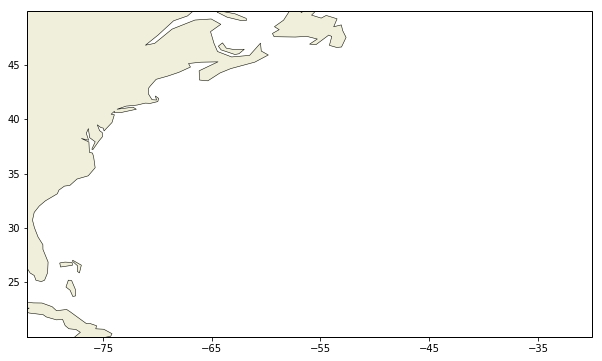

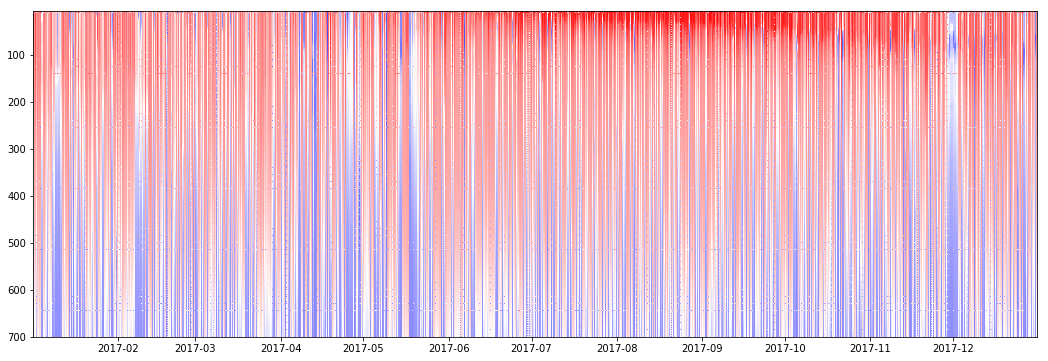

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
print len(dsf.N_PROF)
#MAP
fig=plt.figure(figsize=(22,6))
mproj=ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=mproj)
ax.set_extent([-82, -30, 20, 50], crs=mproj)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.set_xticks(range(-75,-30,10), crs=mproj)
ax.set_yticks(range(25,50,5), crs=mproj)
az.plot(dsf.longitude,dsf.latitude,'o',markersize=3)
#PROFILES
plt.figure(figsize=(18,6))
plt.pcolor(pd.to_datetime(dsf.juld.values,unit='D',origin=pd.to_datetime('1950/1/1')),
                          dsf.DEPTH,dsf.temp.transpose(),cmap='bwr',vmin=-5.,vmax=30.)
plt.gca().invert_yaxis()

plt.show()